# Ford GoBike System Data Exploration
## by Muhammad Ghazal

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print statistics
bike_share = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# high-level overview of data shape and composition
print(bike_share.shape)
print(bike_share.dtypes)
print(bike_share.head(10))

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object
   duration_sec                start_time                  end_time  \
0         52185  2019-02-28 17:32:10.1450  2019-03-01 08:01:55.9750   
1         42521  2019-02-28 18:53:21.7890  2019-03-01 06:42:03.0560   
2         61854  2019-02-28 12:13:13.2180  2019-03-01 05:24:08.1460   
3         36490  2019-02-28 17:54:26.0100  2019-03-01 04:02:36.8420   
4          1585  2019-02-28 23:54:18.5490  2019-03-01 00:2

In [4]:
# Checking the number of nulls in the dataset and removing them if they exist
print(bike_share.isnull().sum().sum())
bike_share = bike_share.dropna()
print(bike_share.isnull().sum().sum())
bike_share = bike_share.reset_index(drop=True)

17318
0


In [5]:
# Checking the duplicates and removing them if they exist
print(bike_share.duplicated().sum())

0


In [6]:
# Extracting dates only without time from start_time and end_time columns
def splits(string):
    """Extracting the substring that is before the whitespace."""
    date = string.split(" ")[0]
    return date

bike_share.start_time = bike_share.start_time.apply(splits)
bike_share.end_time = bike_share.end_time.apply(splits)
print(bike_share[['start_time', 'end_time']])

        start_time    end_time
0       2019-02-28  2019-03-01
1       2019-02-28  2019-03-01
2       2019-02-28  2019-03-01
3       2019-02-28  2019-03-01
4       2019-02-28  2019-03-01
...            ...         ...
174947  2019-02-01  2019-02-01
174948  2019-02-01  2019-02-01
174949  2019-02-01  2019-02-01
174950  2019-02-01  2019-02-01
174951  2019-02-01  2019-02-01

[174952 rows x 2 columns]


In [7]:
# Changing data types of specific columns to appropriate types
changes = {"start_station_id": "int64", 
           "end_station_id": "int64", 
           "member_birth_year": "int64"}

changes2 = {"start_time": "datetime64[ns]", 
           "end_time": "datetime64[ns]", 
           "start_station_id": "object", 
           "end_station_id": "object", 
           "bike_id": "object",
           "member_birth_year": "object",
           "member_gender": "category",
           "bike_share_for_all_trip": "category",
           "user_type": "category"}
bike_share = bike_share.astype(changes)
bike_share = bike_share.astype(changes2)
bike_share = bike_share.rename(columns={"start_time": "start_date", "end_time": "end_date"})
print(bike_share.dtypes)

duration_sec                        int64
start_date                 datetime64[ns]
end_date                   datetime64[ns]
start_station_id                   object
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                     object
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                            object
user_type                        category
member_birth_year                  object
member_gender                    category
bike_share_for_all_trip          category
dtype: object


In [8]:
# descriptive statistics for numeric variables
print(bike_share.describe())

        duration_sec  start_station_latitude  start_station_longitude  \
count  174952.000000           174952.000000            174952.000000   
mean      704.002744               37.771220              -122.351760   
std      1642.204905                0.100391                 0.117732   
min        61.000000               37.317298              -122.453704   
25%       323.000000               37.770407              -122.411901   
50%       510.000000               37.780760              -122.398279   
75%       789.000000               37.797320              -122.283093   
max     84548.000000               37.880222              -121.874119   

       end_station_latitude  end_station_longitude  
count         174952.000000          174952.000000  
mean              37.771414            -122.351335  
std                0.100295               0.117294  
min               37.317298            -122.453704  
25%               37.770407            -122.411647  
50%               37.781

### What is the structure of your dataset?

There are 174952 trips in the dataset. Each trip is anonymized and includes:
* duration_sec: Trip Duration(seconds)
* start_date
* end_date
* start_station_id
* start_station_name
* start_station_latitude
* end_station_id
* end_station_name
* end_station_latitude
* end_station_longitude
* bike_id
* user_type(Subscriber or Customer - "Subscriber" = Member or "Customer" = Casual)
* member_birth_year
* member_gender: Female or Male or Other
* bike_share_for_all_trip: it is discount pricing for members who are in different external programs such as CalFresh which is a welfare program for low income individuals. Its values are: Yes or No.

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out what features are best for predicting the duration of the trips in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that user type will have the strongest effect on each trip duration. If the user is subscriber, then their trips may be longer. I also think that bike share for all trip, member_gender, and bike_share_for_all_trip will have smaller effect.

## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: duration_sec.

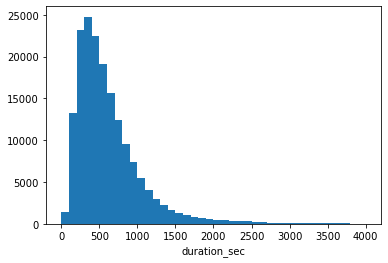

In [9]:
# start with a standard-scaled plot
binsize = 100
bike_share_4000 = bike_share.query("duration_sec < 4000")
bins = np.arange(0, bike_share_4000['duration_sec'].max()+binsize, binsize)
plt.hist(data = bike_share_4000, x = 'duration_sec', bins=bins)
plt.xlabel("duration_sec");

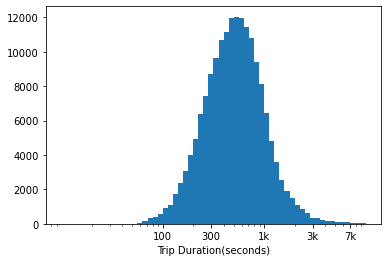

In [10]:
# there's a long tail in the distribution, so let's put it on a log scale instead
bins = 10 ** np.arange(1, 4.05, 0.05)
plt.hist(data = bike_share, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([100, 300, 1000, 3000, 7000], [100, 300, '1k', '3k', '7k'])
plt.xlabel("Trip Duration(seconds)");

duration_sec column has a right skewed distribution, so I filtered the duration_sec column such that it displays the values that are less than 4000 seconds because above that value, there are outliers that make the first plot very small. But in the second plot, I didn't use that filter.
duration_sec has a long-tailed distribution, with a lot of trips on the low duration end, and few on the high duration end. When plotted on a log-scale, the duration distribution looks roughly unimodal, with one peak between 300 and 1000 and it looks like a normal distribution.

Next up, the categorical variables (user_type, member_gender and bike_share_for_all_trip).

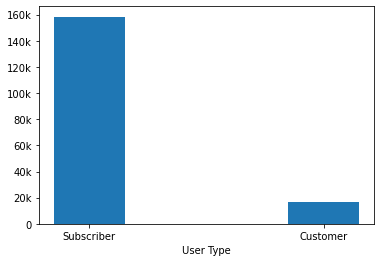

In [11]:
# plotting user_type
values = bike_share.user_type.value_counts().values
x = [1, 2]
plt.bar(x, values, width=0.3)
plt.xticks(x, ['Subscriber', 'Customer'])
yticks = [0, 2e4, 4e4, 6e4, 8e4, 10e4, 12e4, 14e4, 16e4]
yticklabels = [0, '20k', '40k', '60k', '80k', '100k', '120k', '140k', '160k']
plt.yticks(yticks, yticklabels)
plt.xlabel("User Type");

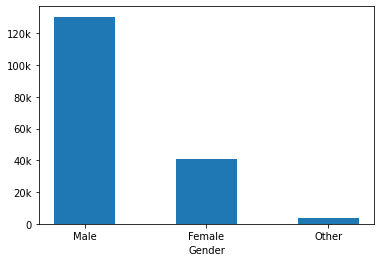

In [12]:
# plotting member_gender
values = bike_share.member_gender.value_counts().values
x = [0, 1, 2]
plt.bar(x, values, width=0.5)
xticklabels=["Male", "Female", "Other"]
plt.xticks(x, xticklabels)
yticks = [0, 20000, 40000, 60000, 80000, 100000, 120000]
yticklabels = [0, '20k', '40k', '60k', '80k', '100k', '120k']
plt.yticks(yticks, yticklabels)
plt.xlabel("Gender");

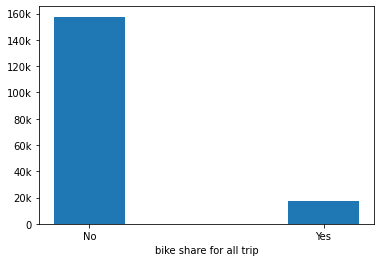

In [13]:
# plotting bike_share_for_all_trip
values = bike_share.bike_share_for_all_trip.value_counts().values
x = [0, 1]
plt.bar(x, values, width=0.3)
yticks = [0, 2e4, 4e4, 6e4, 8e4, 10e4, 12e4, 14e4, 16e4]
yticklabels = [0, '20k', '40k', '60k', '80k', '100k', '120k', '140k', '160k']
xticklabels = ['No', 'Yes']
plt.yticks(yticks, yticklabels)
plt.xticks(x, xticklabels)
plt.xlabel("bike share for all trip");

- In user_type column, most users are subscribers in bike share service. They are about 160k subscribers, while few users are customers which uses bike share in few times. They are about 20k customers. 
- In member_gender column, most of them are males. They are more than 120k males. Some of them are females. They are about 40k females. Few of them are others and they are few thousands. 
- In bike_share_for_all_trip column, Most of the users are not subscribers in different external programs, so they do not have discounting amount on the trips. They are about 160k users. Few of them have discounting amount on the trips. They are about 20k users.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The duration_sec variable took on a large range of values, so I looked at the data using a log transform. Under the transformation, the data looked unimodal and in a normal distribution, with one peak between 300 dollars and 1000 dollars.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

No, there weren't any unusual distributions in the categorical variables:(member_gender, user_type and bike_share_for_all_trip). I changed the data type of them from object to category because the values of them are categorical.

## Bivariate Exploration

To start off with, I want to look at the relationships between log(duration_sec) and the categorical variables:(member_gender, user_type and bike_share_for_all_trip)

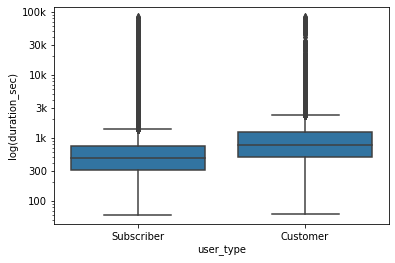

In [17]:
# plotting user_type vs duration_sec
base_color = sb.color_palette()[0]
base_order = ['Subscriber', 'Customer']
sb.boxplot(x = 'user_type', y = 'duration_sec', data=bike_share, order=base_order, color=base_color)
plt.yscale('log')
yticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
yticklabels = [100, 300, '1k', '3k', '10k', '30k', '100k']
plt.yticks(yticks, yticklabels)
plt.ylabel("log(duration_sec)");

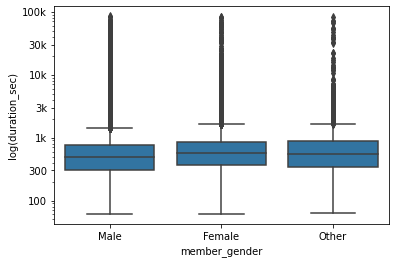

In [15]:
# plotting member_gender vs duration_sec
base_order = ['Male', 'Female', 'Other']
sb.boxplot(x = 'member_gender', y='duration_sec', data=bike_share, order=base_order, color=base_color)
plt.yscale('log')
plt.yticks([100, 300, 1000, 3000, 10000, 30000, 100000], [100, 300, '1k', '3k', '10k', '30k', '100k'])
plt.ylabel("log(duration_sec)");

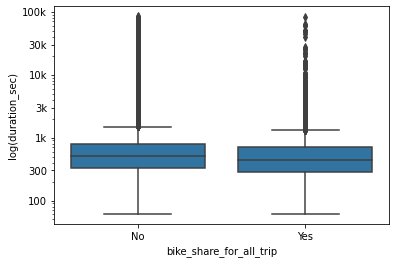

In [16]:
# plotting bike_share_for_all_trip vs duration_sec
base_order = ['No', 'Yes']
sb.boxplot(x='bike_share_for_all_trip', y='duration_sec', data=bike_share, order=base_order, color=base_color)
plt.yscale('log')
yticks=[100, 300, 1000, 3000, 10000, 30000, 100000]
yticklabels = [100, 300, '1k', '3k', '10k', '30k', '100k']
plt.yticks(yticks, yticklabels)
plt.ylabel('log(duration_sec)');

In the plots of the categorical variables vs duration_sec, I used log transformation for duration_sec because it has a large range of values. 
- In the plot between user_type and log(duration_sec), I realized that the median of the durations for customers is higher than for subscribers, which means that in average the customers which are casuals in using bike share service their trips are longer than the subscribers which enrolled in the bike share service for a fee and the outliers of subscribers' durations more than the outliers of customers', the median with customers is about 1k seconds, but it is about 650 seconds with subscribers.
- In the plot between member_gender and log(duration_sec), I realized that the medians of durations with Females and Other are higher than the median of durations with Males, which means that females and other are making long trips comparing with males.
- In the plot between bike_share_for_all_trip and log(duration_sec), I realized that the median of durations with users that haven't discounting amount in trips is slightly higher than the median of durations with users that have discounting amount in trips.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

As I expected, the largest effect was with user_type column, when the user is customer(casual), in average, he will take longer durations in his trip than with the user that is subscriber. The other two columns(member_gender and bike_share_for_all_trip) have smaller effect with duration_sec.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

No, I didn't.

## Multivariate Exploration

The main thing I want to explore in this part of the analysis is how the three categorical measures of quality play into the relationship between each other and duration_sec column.

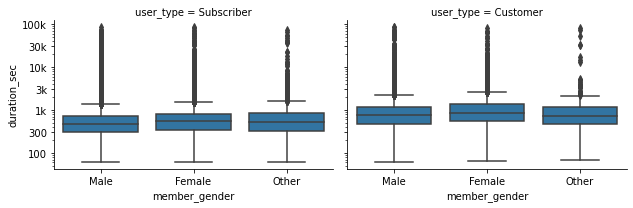

In [26]:
# create faceted box plots between member_gender and log(duration_sec) on levels of the user_type variable
g = sb.FacetGrid(data=bike_share, col='user_type', col_order=['Subscriber', 'Customer'], aspect=1.5)
g.map(sb.boxplot, 'member_gender', 'duration_sec', order=['Male', 'Female', 'Other'])
g.set(yscale='log')
yticks=[100, 300, 1000, 3000, 10000, 30000, 100000]
yticklabels = [100, 300, '1k', '3k', '10k', '30k', '100k']
g.set(yticks=yticks, yticklabels=yticklabels);

In this plot, comparing user_type = Subscriber with user_type = Customer: the subscribers in general with their different genders in average have shorter trips durations than the customers especially with females. Female subscribers has a median between 300 and 1k seconds but female customers have a median about 1k seconds. Also the outliers with subscribers are more than with customers.

C:\Users\Gazal\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


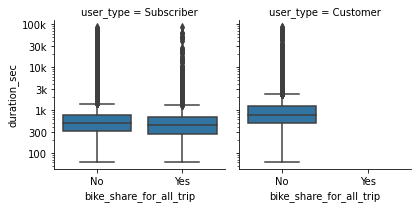

In [31]:
# create faceted box plots between bike_share_for_all_trip and log(duration_sec) on levels of the user_type variable
g = sb.FacetGrid(data=bike_share, col='user_type', col_order=['Subscriber', 'Customer'])
g.map(sb.boxplot, 'bike_share_for_all_trip', 'duration_sec')
g.set(yscale='log')
yticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
yticklabels = [100, 300, '1k', '3k', '10k', '30k', '100k']
g.set(yticks=yticks, yticklabels=yticklabels);

In this plot, subscribers have lower durations in average than customers when they don't subscribe in bike_share_for_all_trip, but I am surprised that no customer have discounting amount on their trips.

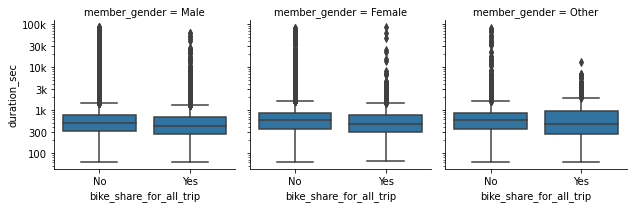

In [36]:
# create faceted box plots between bike_share_for_all_trip and log(duration_sec) on levels of the member_gender variable
g = sb.FacetGrid(data=bike_share, col='member_gender', col_order=['Male', 'Female', 'Other'])
g.map(sb.boxplot, 'bike_share_for_all_trip', 'duration_sec', order=['No', 'Yes'])
g.set(yscale='log')
yticks = [100, 300, 1000, 3000, 10000, 30000, 100000]
yticklabels = [100, 300, '1k', '3k', '10k', '30k', '100k']
g.set(yticks=yticks, yticklabels=yticklabels);

In this plot, the median of males who don't subscribe for bike_share_for_all_trip are less than the median of females and others. The outliers of other users who are subscribers in bike_share_for_all_trip are less than the outliers with males and females.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Customers have longer trip duration than subscribers regardless of their genders or if they subscribed in bike_share_for_all_trip or not. No customer is subscribed in bike_share_for_all_trip and this is maybe because they are casuals not permenant subscriber so the cost of their trips can be paid. Others gender are less likely to subscribe in that program(bike_share_for_all_trip) than Males and Females.

### Were there any interesting or surprising interactions between features?

Yes, I realized in the plot between bike_share_for_all_trip and duration_sec that in average the users who don't subscribe in bike_share_for_all_trip have higher trip durations than who are subscribers in bike_share_for_all_trip, but in the multivariate plot between bike_share_for_all_trip and duration_sec across user_type, I realized that the customers who aren't subscribers in bike_share_for_all_trip in average have higher trip durations than subscribers but no customers are subscribers in bike_share_for_all_trip which affects on the bivariate plot and makes conflict in the result.